**Workshop Instructor: Priscila Ung** 

---
## <center ><h2><span style='color:green'>長短期記憶模型LSTM實作</span></h2></center>

---

# **1. 了解 Colab 的 container 目前 python 環境**
若想對今天實作使用的平台有較多的基礎了解，可到類似以下議題網路文章學習

PYTHON- DATA SCIENCE 資料科學 學習筆記 第1講 - IPYTHON : 更好用的 PYTHON

https://goog-book.blogspot.com/2018/07/python-data-science-1.html

In [ ]:
!pip list
!nvidia-smi

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [1]:
from keras.layers.core import Activation, Dense
from keras.layers.embeddings import Embedding
from keras.layers.recurrent import LSTM,SimpleRNN
from keras.layers import BatchNormalization as BatchNorm
from keras.layers import Dropout
from keras.callbacks import ModelCheckpoint
from keras.models import Sequential
from keras.preprocessing import sequence
from keras.models import load_model
from keras.utils import np_utils
from keras.utils.vis_utils import model_to_dot
from music21 import converter, instrument, note, chord
import glob2 as glob 
from IPython.display import SVG
from music21 import instrument, note, stream, chord
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import collections
import nltk
import math
import numpy as np
import pandas as pd

# **2. 了解 LSTM 應用類型**
LSTM 的應用類型為右邊四種方式，本課程主要運用到「many to one」及「many to many」兩種方式。


> <img src="http://karpathy.github.io/assets/rnn/diags.jpeg" width="690px" align="center">

# **3. LSTM 應用 (1) - 情緒分析 及  RNN之比較**
為了讓大家了解 LSTM 的特性，我們先比較一般遞歸神經網路（RNN）跟 LSTM 的優缺點。

### **LSTM 及 RNN 結構比較**
資料來源:
https://colah.github.io/posts/2015-08-Understanding-LSTMs/




> RNN 結構
> 
> <img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-SimpleRNN.png" width="690px" align="center">

> LSTM 結構
> 
> <img src="https://colah.github.io/posts/2015-08-Understanding-LSTMs/img/LSTM3-chain.png" width="700px" align="center">
> 


> <img src="https://miro.medium.com/proxy/1*goJVQs-p9kgLODFNyhl9zA.gif" width="550px" align="center">

### **數據集相關資訊**

準備了兩組數據集用作參考：
1.   短句電影評論數據來源:   https://github.com/mc6666/MyNeuralNetwork
2.   段落(長句)IMDb電影評論數據來源:  https://ai.stanford.edu/~amaas/data/sentiment/#Movie 

因考量課程及模型訓練之時間，以上數據已預先進行整理或刪減。



In [ ]:
# Loading數據

# ********* 請更改此處 ********* ##

#短句電影評論數據
simple_data = '/content/drive/MyDrive/AI_workshop_LSTM/Data/3_SentimentAnalysis_LSTM/SentimentAnalysisData_simple.txt'  

#段落電影評論數據
complex_data ='/content/drive/MyDrive/AI_workshop_LSTM/Data/3_SentimentAnalysis_LSTM/SentimentAnalysisData_complex.txt'  

path = simple_data


In [ ]:
#下載自然語言處理函數庫 nltk(Natural Language Toolkit)
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
# 計算訓練資料的字句最大字數
maxlen = 0
word_freqs = collections.Counter()
num_recs = 0
with open(path,'r+', encoding='UTF-8') as f:
    for line in f:
        label, sentence = line.strip().split("\t",1)
        words = nltk.word_tokenize(sentence.lower())
        if len(words) > maxlen:
            maxlen = len(words)
        for word in words:
            word_freqs[word] += 1
        if num_recs ==0:
          print('標註答案:',label)
          print('句子:',sentence)
        num_recs += 1
        
print('\n\nmax_len ',maxlen)
print('nb_words ', len(word_freqs))
#print(word_freqs)

標註答案: 1
句子: The Da Vinci Code book is just awesome.


max_len  42
nb_words  2328


In [ ]:
# ********* 請更改此處 ********* ##
MAX_SENTENCE_LENGTH = 40        #simple data:40 或 complex data:140
MAX_FEATURES = 2300          #simple data:2300 或 complex data:11000

In [ ]:
## 準備及處理數據
vocab_size = min(MAX_FEATURES, len(word_freqs)) + 2
print('vocab_size:',vocab_size)
word_index = {x[0]: i+2 for i, x in enumerate(word_freqs.most_common(MAX_FEATURES))}
word_index["PAD"] = 0
word_index["UNK"] = 1
index2word = {v:k for k, v in word_index.items()}
X = np.empty(num_recs,dtype=list)
y = np.zeros(num_recs)
i=0

with open(path,'r+', encoding='UTF-8') as f:
    for line in f:
        label, sentence = line.strip().split("\t",1)
        words = nltk.word_tokenize(sentence.lower())
        seqs = []
        for word in words:
            if word in word_index:
                seqs.append(word_index[word])
            else:
                seqs.append(word_index["UNK"])
        X[i] = seqs
        y[i] = int(label)
        i += 1

        
X = sequence.pad_sequences(X, maxlen=MAX_SENTENCE_LENGTH) # 字句長度不足補空白

vocab_size: 2302


In [ ]:
# 數據處理結果
print('數據處理後:\n',X)
print('\n數據維度:',X.shape)

數據處理後:
 [[  0   0   0 ...  48  22   4]
 [  0   0   0 ... 341  67   4]
 [  0   0   0 ...  18 325   4]
 ...
 [  0   0   0 ...  11  13   4]
 [  0   0   0 ... 127  26   4]
 [  0   0   0 ...  87  26   4]]

數據維度: (7086, 40)


In [ ]:
# 資料劃分訓練組及測試組
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size=0.2, random_state=42)

print('Xtrain.shape ',Xtrain.shape)
print('ytrain.shape ',ytrain.shape)
print('Xtest.shape ',Xtest.shape)
print('ytest.shape ',ytest.shape)

Xtrain.shape  (5668, 40)
ytrain.shape  (5668,)
Xtest.shape  (1418, 40)
ytest.shape  (1418,)


In [ ]:

EMBEDDING_SIZE = 128 
HIDDEN_LAYER_SIZE = 64
BATCH_SIZE = 32
NUM_EPOCHS = 5

In [ ]:
LSTMmodel = Sequential()
LSTMmodel.add(Embedding(vocab_size, EMBEDDING_SIZE,input_length=MAX_SENTENCE_LENGTH))
LSTMmodel.add(LSTM(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
LSTMmodel.add(Dense(1))
LSTMmodel.add(Activation("sigmoid"))
LSTMmodel.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
LSTMmodel.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 40, 128)           294656    
_________________________________________________________________
lstm_6 (LSTM)                (None, 64)                49408     
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation (Activation)      (None, 1)                 0         
Total params: 344,129
Trainable params: 344,129
Non-trainable params: 0
_________________________________________________________________


**參數計算**

以短句電影評論數據參數為例：

> **Embedding層參數** = vocab_size x embedding size(輸出維度) = 2302 x 128 = 294656

> **LSTM層參數** = ((上層維度+hidden size)x hidden size + hidden_size)x4
=((128+64)x64+64)x4 = 49408

> **Dense層參數** = (上層維度+1) x hidden size = (64+1)x1 =65

In [ ]:
# 訓練LSTM模型
LSTMmodel.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,validation_data=(Xtest, ytest))

Epoch 1/5
178/178 [==============================] - 19s 81ms/step - loss: 0.4248 - accuracy: 0.7858 - val_loss: 0.0670 - val_accuracy: 0.9767
Epoch 2/5
178/178 [==============================] - 13s 75ms/step - loss: 0.0277 - accuracy: 0.9937 - val_loss: 0.0490 - val_accuracy: 0.9824
Epoch 3/5
178/178 [==============================] - 13s 75ms/step - loss: 0.0152 - accuracy: 0.9954 - val_loss: 0.0393 - val_accuracy: 0.9866
Epoch 4/5
178/178 [==============================] - 13s 76ms/step - loss: 0.0052 - accuracy: 0.9987 - val_loss: 0.0461 - val_accuracy: 0.9845
Epoch 5/5
178/178 [==============================] - 13s 75ms/step - loss: 0.0021 - accuracy: 0.9996 - val_loss: 0.0443 - val_accuracy: 0.9887


In [ ]:
# 建立RNN模型
RNNmodel = Sequential()
RNNmodel.add(Embedding(vocab_size, EMBEDDING_SIZE,input_length=MAX_SENTENCE_LENGTH))
RNNmodel.add(SimpleRNN(HIDDEN_LAYER_SIZE, dropout=0.2, recurrent_dropout=0.2))
RNNmodel.add(Dense(1))
RNNmodel.add(Activation("sigmoid"))
RNNmodel.compile(loss="binary_crossentropy", optimizer="adam",metrics=["accuracy"])
RNNmodel.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 40, 128)           294656    
_________________________________________________________________
simple_rnn (SimpleRNN)       (None, 64)                12352     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 65        
_________________________________________________________________
activation_1 (Activation)    (None, 1)                 0         
Total params: 307,073
Trainable params: 307,073
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# RNN模型訓練
RNNmodel.fit(Xtrain, ytrain, batch_size=BATCH_SIZE, epochs=NUM_EPOCHS,validation_data=(Xtest, ytest))

Epoch 1/5
178/178 [==============================] - 6s 23ms/step - loss: 0.5252 - accuracy: 0.7164 - val_loss: 0.1124 - val_accuracy: 0.9591
Epoch 2/5
178/178 [==============================] - 4s 20ms/step - loss: 0.0893 - accuracy: 0.9686 - val_loss: 0.0584 - val_accuracy: 0.9746
Epoch 3/5
178/178 [==============================] - 3s 20ms/step - loss: 0.0284 - accuracy: 0.9902 - val_loss: 0.0641 - val_accuracy: 0.9732
Epoch 4/5
178/178 [==============================] - 3s 19ms/step - loss: 0.0159 - accuracy: 0.9950 - val_loss: 0.0715 - val_accuracy: 0.9760
Epoch 5/5
178/178 [==============================] - 4s 20ms/step - loss: 0.0120 - accuracy: 0.9960 - val_loss: 0.0544 - val_accuracy: 0.9845


In [ ]:
models={'LSTM model':LSTMmodel,'RNN model':RNNmodel}

In [ ]:
# 模型驗證結果


for key,value in models.items():
  print('------------------------------- {} Result -------------------------------'.format(key))
  print('{}   {}      {}'.format('預測','真實','句子'))
  for idx in range(10):
      #idx = np.random.randint(len(Xtest))
      xtest = Xtest[idx].reshape(1,MAX_SENTENCE_LENGTH)
      ylabel = ytest[idx]
      ypred = value.predict(xtest)[0][0]
      sent = " ".join([index2word[x] for x in xtest[0] if x != 0])
      print(' {}      {}        {}'.format(int(round(ypred)), int(ylabel), sent))
  score, acc = value.evaluate(Xtest, ytest, batch_size=BATCH_SIZE)
  print("Test score: %.4f, accuracy: %.4f\n\n" % (score, acc))
        
      

-------------------------------LSTM model Result-------------------------------
預測   真實      句子
 1      1        i love harry potter .
 0      0        is it just me , or does harry potter suck ? ...
 1      1        the da vinci code was awesome , i ca n't wait to read it ...
 0      0        brokeback mountain is fucking horrible..
 0      0        not because i hate harry potter , but because i am the type of person that likes it when the main character dies .
 1      1        i want to be here because i love harry potter , and i really want a place where people take it serious , but it is still so much fun .
 1      1        love luv lubb the da vinci code !
 0      0        , she helped me bobbypin my insanely cool hat to my head , and she laughed at my stupid brokeback mountain cowboy jokes..
 1      1        i want to be here because i love harry potter , and i really want a place where people take it serious , but it is still so much fun .
 0      0        harry potter dragged 

In [ ]:
#可手動輸入測試
simple_data_input = ['I love it.', 'It is so boring.']

complex_data_input = ['One of the funniest, most romantic, and most musical movies ever; definitely worth renting/buying especially if you have a taste for older style of cinematography.<br /><br /> The animals and the songs alone will make you smile while watching the movie. A definite must for Madonna fans. :o)',\
          'Mercy the movie, actually starts out as a somewhat decent film, and ellen barkin does give a strong performance. But if you have read the book and actually got to know the characters and cared who done it the movie just does not compare. It is always hard to brink a book onto film and unfortunatley this one ends up failing...... 3 out of 10']

In [ ]:
# ********* 請更改此處 ********* ##
INPUT_SENTENCES = simple_data_input       # simple_data_input 或 complex_data_input

In [ ]:
for key,value in models.items():
  print('------------------------------- {} Result -------------------------------'.format(key))
  XX = np.empty(len(INPUT_SENTENCES),dtype=list)
  # 轉換文字為數值
  i=0
  for sentence in  INPUT_SENTENCES:
      words = nltk.word_tokenize(sentence.lower())
      seq = []
      for word in words:
          if word in word_index:
              seq.append(word_index[word])
          else:
              seq.append(word_index['UNK'])
      XX[i] = seq
      i+=1

  XX = sequence.pad_sequences(XX, maxlen=MAX_SENTENCE_LENGTH)
  labels = [int(round(x[0])) for x in value.predict(XX) ]
  label2word = {1:'正面', 0:'負面'}
  
  for i in range(len(INPUT_SENTENCES)):
      print('預測結果為 {}({})   {}'.format(labels[i], label2word[labels[i]], INPUT_SENTENCES[i]))
  print("\n")

-------------------------------LSTM model Result-------------------------------
預測結果為 1(正面)   I love it.
預測結果為 0(負面)   It is so boring.


-------------------------------RNN model Result-------------------------------
預測結果為 1(正面)   I love it.
預測結果為 0(負面)   It is so boring.




In [ ]:
# 模型存檔
LSTMmodel.save('./SentimentAnalysis_LSTM.h5')  # creates a HDF5 file 'model.h5'
RNNmodel.save('./SentimentAnalysis_RNN.h5') 

# **4. LSTM 應用 (2) - 時序資料預測**
LSTM 除了可應用在自然語言上，還可以應用在單純的數據型資料上。本課程以股價預測作為範例。

### **數據集相關資訊**

準備了美股台積電TSM數據以作參考，數據來源: https://finance.yahoo.com/quote/TSM/history?p=TSM

大家如有興趣，可於網站內下載其他股票來練習。



In [ ]:
# Loading數據

# ********* 請更改此處 ********* ##
stock_data_path = '/content/drive/MyDrive/AI_workshop_LSTM/Data/4_StockLSTM/TSM.csv'  



In [ ]:
# Loading數據
data = pd.read_csv(stock_data_path,header=0,index_col=0,parse_dates=True)
dataset = data.loc[:,"Open":"Close"]
dataset = dataset.drop(index=dataset.index.tolist()[-1])
print(dataset)

                  Open        High         Low       Close
Date                                                      
1997-10-06    5.646040    7.040944    5.646040    6.615830
1997-10-13    6.629115    6.629115    5.327205    5.340490
1997-10-20    4.463693    5.340490    4.091718    4.197997
1997-10-27    4.091718    4.463693    3.321200    4.197997
1997-11-03    4.569971    5.420198    4.569971    5.061509
...                ...         ...         ...         ...
2021-05-17  109.070000  114.000000  107.870003  111.849998
2021-05-24  112.260002  117.839996  112.120003  117.360001
2021-05-31  119.709999  120.040001  116.459999  119.510002
2021-06-07  118.139999  118.849998  115.059998  118.250000
2021-06-14  118.550003  122.000000  117.500000  118.019997

[1237 rows x 4 columns]


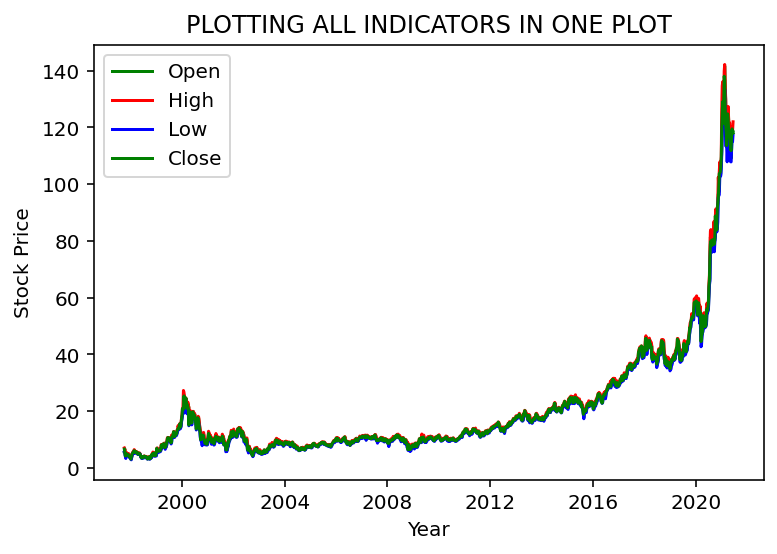

In [ ]:
# 了解數據
obs = dataset.index.tolist()
plt.plot(obs, dataset['Open'], 'g', label = 'Open')  #Open(開盤價)
plt.plot(obs, dataset['High'], 'r', label = 'High')  #High(最高價)
plt.plot(obs, dataset['Low'], 'b', label = 'Low')   #Low(最低價)
plt.plot(obs, dataset['Close'], 'g', label = 'Close') #Close(收盤價)
plt.legend(loc = 'upper left')
plt.ylabel('Stock Price')
plt.xlabel('Year')
plt.title('PLOTTING ALL INDICATORS IN ONE PLOT')
plt.show()

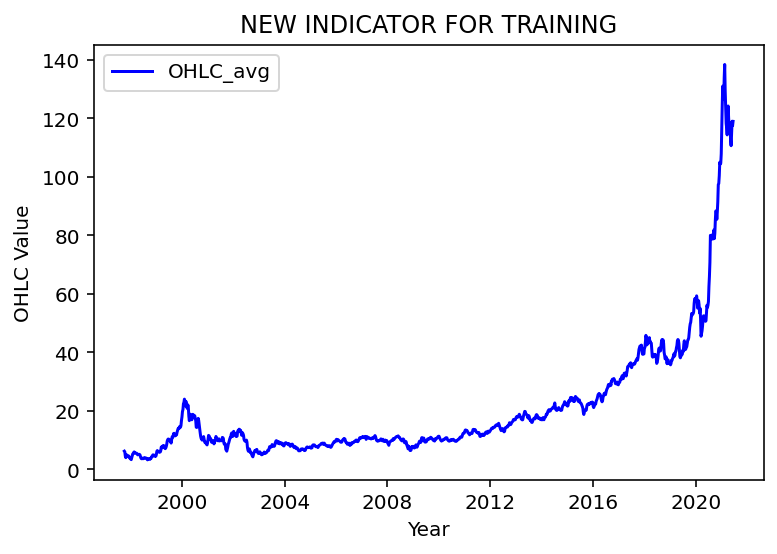

In [ ]:
# 製作數據
OHLC_avg = dataset.mean(axis = 1)
plt.plot(obs, OHLC_avg, 'b', label = 'OHLC_avg')
plt.legend(loc = 'upper left')
plt.title('NEW INDICATOR FOR TRAINING')
plt.ylabel('OHLC Value')
plt.xlabel('Year')
plt.show()

In [ ]:
# ********* 請更改此處 ********* ##
# 需入資料時間間隔數(週)
step_size = 3 

In [ ]:
# 數據處理


# 進行最小最大值標準化(MinMaxScaler)，數據會縮放到到[0,1]之間。
OHLC_avg = np.reshape(OHLC_avg.values, (len(OHLC_avg),1)) 
scaler = MinMaxScaler(feature_range=(0, 1))
OHLC_avg = scaler.fit_transform(OHLC_avg)


# 資料劃分訓練組及測試組
train_OHLC = int(len(OHLC_avg) * 0.8)
test_OHLC = len(OHLC_avg) - train_OHLC
train_OHLC, test_OHLC = OHLC_avg[0:train_OHLC,:], OHLC_avg[train_OHLC:len(OHLC_avg),:]

def new_dataset(dataset, step_size):
	data_X, data_Y = [], []
	for i in range(len(dataset)-step_size-1):
		a = dataset[i:(i+step_size), 0]
		data_X.append(a)
		data_Y.append(dataset[i + step_size, 0])
	return np.array(data_X), np.array(data_Y)

# 製作時間間隔數據
trainX, trainY = new_dataset(train_OHLC, step_size)
testX, testY = new_dataset(test_OHLC, step_size)
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))
timesteps = trainX.shape[1]
data_dim = trainX.shape[2] 

print('trainX.shape ',trainX.shape)
print('trainY.shape ',trainY.shape)
print('testX.shape  ',testX.shape)
print('testY.shape  ',testY.shape)

trainX.shape  (985, 3, 1)
trainY.shape  (985,)
testX.shape   (244, 3, 1)
testY.shape   (244,)


In [ ]:
# 訓練組資料再分出驗證資料
x_train, x_val, y_train, y_val = train_test_split(trainX, trainY, train_size=0.9, shuffle=False)
print('x_train.shape ',x_train.shape)
print('y_train.shape  ',y_train.shape)
print('x_val.shape ',x_val.shape)
print('y_val.shape  ',y_val.shape)

x_train.shape  (886, 3, 1)
y_train.shape   (886,)
x_val.shape  (99, 3, 1)
y_val.shape   (99,)


In [ ]:
# 建立LSTM模型
model = Sequential()
model.add(LSTM(32, input_shape=(timesteps, data_dim), return_sequences = True))
model.add(LSTM(16))
model.add(Dense(1))

model.compile(loss='mean_squared_error', optimizer='adam') # optimizer 可自行比較 SGD, adam, adagrad
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 3, 32)             4352      
_________________________________________________________________
lstm_1 (LSTM)                (None, 16)                3136      
_________________________________________________________________
dense (Dense)                (None, 1)                 17        
Total params: 7,505
Trainable params: 7,505
Non-trainable params: 0
_________________________________________________________________


**參數計算**

**LSTM層參數** = **((上層維度+hidden size)x hidden size + hidden_size)x4**

> LSTM層(1) = ((1+32)x32+32)x4 = 4352

> LSTM層(2) = ((32+16)x16+16)x4 = 3136

**Dense層參數** = (上層維度+1) x hidden size= (16+1)*1=17

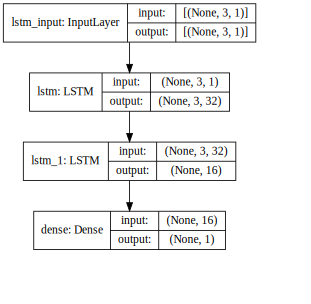

In [ ]:
SVG(model_to_dot(model,show_shapes=True,dpi=60).create(prog='dot', format='svg'))

In [ ]:
# LSTM模型訓練
history = model.fit(x_train, y_train, validation_data=(x_val, y_val),  epochs=10, batch_size=10)

Epoch 1/10
89/89 [==============================] - 37s 69ms/step - loss: 0.0013 - val_loss: 0.0026
Epoch 2/10
89/89 [==============================] - 4s 47ms/step - loss: 1.6567e-04 - val_loss: 4.6130e-05
Epoch 3/10
89/89 [==============================] - 4s 47ms/step - loss: 3.4016e-05 - val_loss: 4.5740e-05
Epoch 4/10
89/89 [==============================] - 4s 46ms/step - loss: 3.4068e-05 - val_loss: 4.8760e-05
Epoch 5/10
89/89 [==============================] - 4s 46ms/step - loss: 3.6856e-05 - val_loss: 4.4966e-05
Epoch 6/10
89/89 [==============================] - 4s 48ms/step - loss: 3.6235e-05 - val_loss: 4.3304e-05
Epoch 7/10
89/89 [==============================] - 4s 47ms/step - loss: 3.4283e-05 - val_loss: 6.2349e-05
Epoch 8/10
89/89 [==============================] - 4s 47ms/step - loss: 3.7971e-05 - val_loss: 4.2505e-05
Epoch 9/10
89/89 [==============================] - 4s 46ms/step - loss: 3.5984e-05 - val_loss: 6.3454e-05
Epoch 10/10
89/89 [=========================

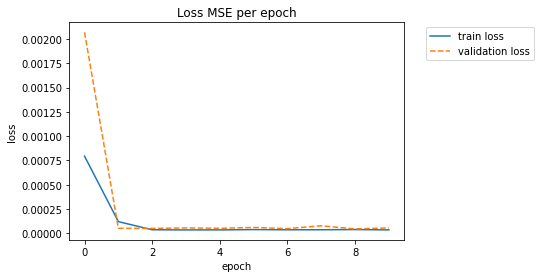

In [ ]:
plt.plot(history.history['loss'], '-',label='train loss')
plt.plot(history.history['val_loss'], '--',label='validation loss')
plt.title('Loss MSE per epoch')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(bbox_to_anchor=(1.05,1.0), loc='upper left')
plt.show()

In [ ]:
# 模型驗證
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
trainPredict_denorm = scaler.inverse_transform(trainPredict)
trainY_denorm = scaler.inverse_transform([trainY])
testPredict_denorm = scaler.inverse_transform(testPredict)
testY_denorm = scaler.inverse_transform([testY])
OHLC_avg = scaler.inverse_transform(OHLC_avg)

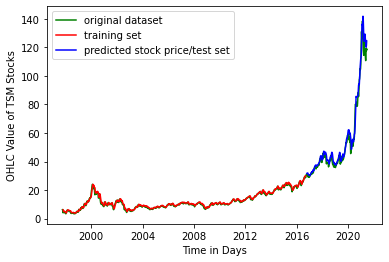

In [ ]:
# 驗證結果視覺化呈現
trainPredictPlot = np.empty_like(OHLC_avg)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[step_size:len(trainPredict_denorm)+step_size, :] = trainPredict_denorm

testPredictPlot = np.empty_like(OHLC_avg)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict_denorm)+(step_size*2)+1:len(OHLC_avg)-1, :] = testPredict_denorm

plt.plot(obs,OHLC_avg, 'g', label = 'original dataset')
plt.plot(obs,trainPredictPlot, 'r', label = 'training set')
plt.plot(obs,testPredictPlot, 'b', label = 'predicted stock price/test set')
plt.legend(loc = 'upper left')
plt.xlabel('Time in Days')
plt.ylabel('OHLC Value of TSM Stocks')
plt.show()

In [ ]:
# 計算驗證結果RMSE
trainScore = math.sqrt(mean_squared_error(trainY_denorm[0], trainPredict_denorm[:,0]))
print('訓練集RMSE: %.2f' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY_denorm[0], testPredict_denorm[:,0]))
print('測試集RMSE: %.2f' % (testScore))


訓練集RMSE: 0.84
測試集RMSE: 4.25


# **5. LSTM 應用 (3) - 與CNN之聯合應用**
為了呼應前面的CNN課程, 跟大家介紹 CNN 與 LSTM 合併所衍生出的 Convolutional LSTM (ConvLSTM)，同時讓大家了解 LSTM 於圖像或影像上之應用。

我們以keras的官方範例示範給大家:
https://keras.io/examples/vision/conv_lstm/





In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import io
import imageio
from IPython.display import Image, display
from ipywidgets import widgets, Layout, HBox

In [ ]:
# 數據下載
fpath = keras.utils.get_file("moving_mnist.npy",
    "http://www.cs.toronto.edu/~nitish/unsupervised_video/mnist_test_seq.npy")

dataset = np.load(fpath)
dataset = np.swapaxes(dataset, 0, 1)

# 本課程只用100筆資料
dataset = dataset[:100, ...]

# 由於圖片為灰階圖，需再增加一維度
dataset = np.expand_dims(dataset, axis=-1)

print('dataset.shape:',dataset.shape)

819208192/819200096 [==============================] - 27s 0us/step
dataset.shape: (100, 20, 64, 64, 1)


In [ ]:
# 資料劃分訓練組及測試組
indexes = np.arange(dataset.shape[0])
np.random.shuffle(indexes)
train_index = indexes[: int(0.9 * dataset.shape[0])]
val_index = indexes[int(0.9 * dataset.shape[0]) :]
train_dataset = dataset[train_index]
val_dataset = dataset[val_index]

# 進行數據準化，數據會縮放到到[0,1]之間。
train_dataset = train_dataset / 255
val_dataset = val_dataset / 255

In [ ]:
# 定義 X(frames 0 至 n-1) 及 Y(1 至 n)

def create_shifted_frames(data):
    x = data[:, 0 : data.shape[1] - 1, :, :]
    y = data[:, 1 : data.shape[1], :, :]
    return x, y

x_train, y_train = create_shifted_frames(train_dataset)
x_val, y_val = create_shifted_frames(val_dataset)


print("訓練集 shapes: " + str(x_train.shape) + ", " + str(y_train.shape))
print("測試集 shapes: " + str(x_val.shape) + ", " + str(y_val.shape))

訓練集 shapes: (90, 19, 64, 64, 1), (90, 19, 64, 64, 1)
測試集 shapes: (10, 19, 64, 64, 1), (10, 19, 64, 64, 1)


Displaying frames for example 62.


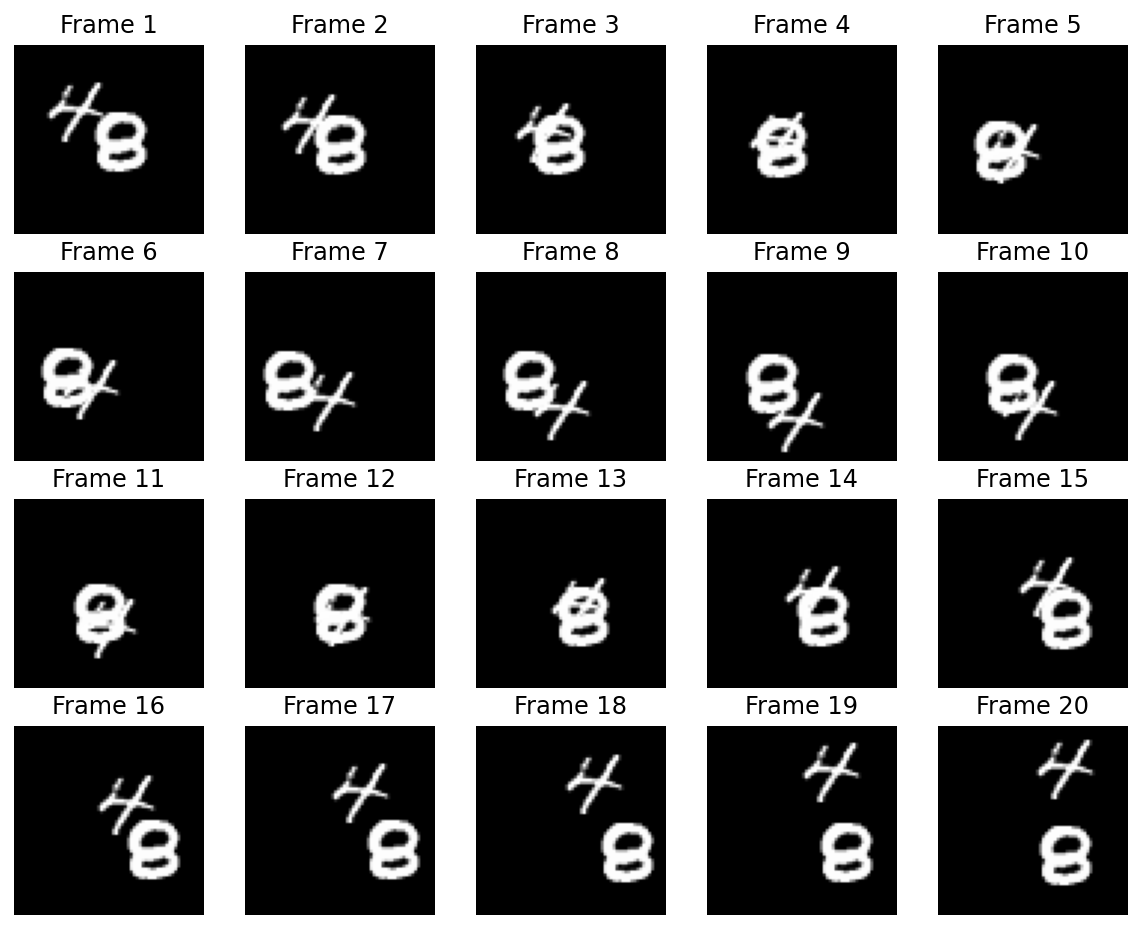

In [ ]:
# 隨機從訓練集選一個樣本來視覺化給大家看

fig, axes = plt.subplots(4, 5, figsize=(10, 8))

data_choice = np.random.choice(range(len(train_dataset)), size=1)[0]
for idx, ax in enumerate(axes.flat):
  ax.imshow(train_dataset[data_choice][idx].squeeze(), cmap="gray")#
  ax.set_title(f"Frame {idx + 1}")
  ax.axis("off")


print(f"Displaying frames for example {data_choice}.")
plt.show()

In [ ]:
# 建立模型
inp = layers.Input(shape=(None, *x_train.shape[2:])) 

x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(5, 5),
    padding="same",
    return_sequences=True,
    activation="relu",)(inp)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(
    filters=64,
    kernel_size=(3, 3),
    padding="same",
    return_sequences=True,
    activation="relu")(x)
x = layers.BatchNormalization()(x)
x = layers.ConvLSTM2D(filters=64,
    kernel_size=(1, 1),
    padding="same",
    return_sequences=True,
    activation="relu")(x)
x = layers.Conv3D(filters=1, kernel_size=(3, 3, 3), activation="sigmoid", padding="same")(x)

model = keras.models.Model(inp, x)
model.compile(loss=keras.losses.binary_crossentropy, optimizer=keras.optimizers.Adam())
early_stopping = keras.callbacks.EarlyStopping(monitor="val_loss", patience=10)
reduce_lr = keras.callbacks.ReduceLROnPlateau(monitor="val_loss", patience=5)

In [ ]:
##********* 請輸入權重檔案路徑 ********* ##
model.load_weights('/content/drive/MyDrive/AI_workshop_LSTM/Data/5_ConvLSTM/model_weights_movingmnist.h5')

In [ ]:
# 訓練模型
epochs = 3
batch_size = 5

model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    validation_data=(x_val, y_val),
    callbacks=[early_stopping, reduce_lr])

Epoch 1/3


KeyboardInterrupt: ignored

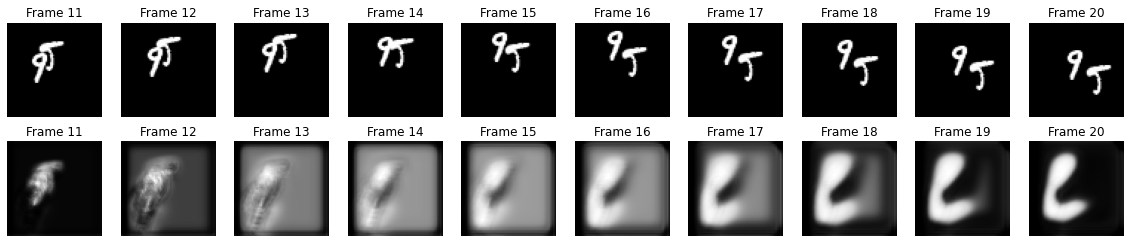

In [ ]:
# 隨機從測試集中選一組數據，以多幀圖片來展示預測結束
example = val_dataset[np.random.choice(range(len(val_dataset)), size=1)[0]]


frames = example[:10, ...]
original_frames = example[10:, ...]


for _ in range(10):
    new_prediction = model.predict(np.expand_dims(frames, axis=0))
    new_prediction = np.squeeze(new_prediction, axis=0)
    predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)
    frames = np.concatenate((frames, predicted_frame), axis=0)

# 呈現原圖結果與測試結果之比較圖
fig, axes = plt.subplots(2, 10, figsize=(20, 4))

for idx, ax in enumerate(axes[0]):
    ax.imshow(np.squeeze(original_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

new_frames = frames[10:, ...]
for idx, ax in enumerate(axes[1]):
    ax.imshow(np.squeeze(new_frames[idx]), cmap="gray")
    ax.set_title(f"Frame {idx + 11}")
    ax.axis("off")

plt.show()

In [ ]:
# 隨機從測試集中選多組數據，以動畫方式來展示預測結束
examples = val_dataset[np.random.choice(range(len(val_dataset)), size=5)]

predicted_videos = []
for example in examples:
    frames = example[:10, ...]
    original_frames = example[10:, ...]
    new_predictions = np.zeros(shape=(10, *frames[0].shape))

    for i in range(10):
        frames = example[: 10 + i + 1, ...]
        new_prediction = model.predict(np.expand_dims(frames, axis=0))
        new_prediction = np.squeeze(new_prediction, axis=0)
        predicted_frame = np.expand_dims(new_prediction[-1, ...], axis=0)       
        new_predictions[i] = predicted_frame

    # 以GIF影像呈現
    for frame_set in [original_frames, new_predictions]:
        current_frames = np.squeeze(frame_set)
        current_frames = current_frames[..., np.newaxis] * np.ones(3)
        current_frames = (current_frames * 255).astype(np.uint8)
        current_frames = list(current_frames)

        with io.BytesIO() as gif:
            imageio.mimsave(gif, current_frames, "GIF", fps=5)
            predicted_videos.append(gif.getvalue())

print("   真實    預測")
for i in range(0, len(predicted_videos), 2):
    # Construct and display an `HBox` with the ground truth and prediction.
    box = HBox([ widgets.Image(value=predicted_videos[i]),widgets.Image(value=predicted_videos[i + 1])])
    display(box)

   真實    預測


# **6. LSTM 應用 (4) - 其他應用**
為了讓各位了解LSTM還可以用在不同的資料上, 這是給大家額外的參考。此為以利用不同的音樂訓練出模型後，讓模型可以自行產出新的歌曲。

音樂範例連結如下:


1.   https://towardsdatascience.com/how-to-generate-music-using-a-lstm-neural-network-in-keras-68786834d4c5
2.   https://github.com/Skuldur/Classical-Piano-Composer
3.   https://audio.online-convert.com/convert/midi-to-wav

> <img src="https://miro.medium.com/max/939/1*YpnnaPA1Sm8rzTR4N2knKQ.jpeg" width="690px" align="center">




In [2]:
!git clone https://github.com/Skuldur/Classical-Piano-Composer.git

Cloning into 'Classical-Piano-Composer'...
remote: Enumerating objects: 334, done.
remote: Total 334 (delta 0), reused 0 (delta 0), pack-reused 334
Receiving objects: 100% (334/334), 721.79 MiB | 12.76 MiB/s, done.
Resolving deltas: 100% (41/41), done.


In [11]:
# ********* 請輸入midi_songs資料夾路徑 ********* ##
path = '/content/Classical-Piano-Composer/midi_songs'

In [12]:
# 數據下載

notes = []
path = path+"/*.mid"

#範例原用92首歌曲進行訓練，但考量訓練時間只用10首歌曲進行訓練。
for file in glob.glob(path)[0:10]:
    midi = converter.parse(file)
    notes_to_parse = None
    parts = instrument.partitionByInstrument(midi)
    if parts:
        notes_to_parse = parts.parts[0].recurse()
    else:
        notes_to_parse = midi.flat.notes
    for element in notes_to_parse:
        if isinstance(element, note.Note):
            notes.append(str(element.pitch))
        elif isinstance(element, chord.Chord):
            notes.append('.'.join(str(n) for n in element.normalOrder))

In [13]:
#數據處理及轉化

sequence_length = 100
# 找出音高(Pitch)名字
pitchnames = sorted(set(item for item in notes))
n_vocab=len(pitchnames)

note_to_int = dict((note, number) for number, note in enumerate(pitchnames))
network_input = []
network_output = []

for i in range(0, len(notes) - sequence_length, 1):
    sequence_in = notes[i:i + sequence_length]
    sequence_out = notes[i + sequence_length]
    network_input.append([note_to_int[char] for char in sequence_in])
    network_output.append(note_to_int[sequence_out])
n_patterns = len(network_input)

network_input = np.reshape(network_input, (n_patterns, sequence_length, 1))

network_input = network_input / float(n_vocab)
network_output = np_utils.to_categorical(network_output)
print('network_input.shape:',network_input.shape)
print('network_output.shape:',network_output.shape)

network_input.shape: (5913, 100, 1)
network_output.shape: (5913, 161)


In [14]:
# 模型建立
model = Sequential()
model.add(LSTM(
    512,
    input_shape=(network_input.shape[1], network_input.shape[2]),
    recurrent_dropout=0.3,
    return_sequences=True
    ))
model.add(LSTM(512, return_sequences=True, recurrent_dropout=0.3,))
model.add(LSTM(512))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(256))
model.add(Activation('relu'))
model.add(BatchNorm())
model.add(Dropout(0.3))
model.add(Dense(n_vocab))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='rmsprop')

In [15]:
# 因訓練時間太長，故直接下載已訓練好的模型

# ********* 請輸入 music_weights.hdf5 檔案路徑 ********* ##
model_path = '/content/drive/MyDrive/AI_workshop_LSTM/Data/6_MusicLSTM/music_weights.h5'
model.load_weights(model_path, by_name = True)

#如想自行訓練，請用以下指令
#model.fit(network_input, network_output, epochs=20, batch_size=256)
#model.save_weights('/content/drive/MyDrive/AI_workshop_LSTM/Data/6_MusicLSTM/music_weights.h5')

In [16]:
# 進行預測並產生200個音符
start = np.random.randint(0, len(network_input)-1)
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
pattern = network_input[start]
prediction_output = []

for note_index in range(200):
    prediction_input = np.reshape(pattern, (1, len(pattern), 1))
    prediction_input = prediction_input / float(n_vocab)
    prediction = model.predict(prediction_input, verbose=0)
    index = np.argmax(prediction)
    result = int_to_note[index]
    prediction_output.append(result)
    pattern = np.append(pattern,index)
    pattern = pattern[1:len(pattern)]

In [ ]:
#音符及和弦處理，並生成音樂
offset = 0
output_notes = []

for pattern in prediction_output:
    # pattern is a chord
    if ('.' in pattern) or pattern.isdigit():
        notes_in_chord = pattern.split('.')
        notes = []
        for current_note in notes_in_chord:
            new_note = note.Note(int(current_note))
            new_note.storedInstrument = instrument.Piano()
            notes.append(new_note)
        new_chord = chord.Chord(notes)
        new_chord.offset = offset
        output_notes.append(new_chord)
    # pattern is a note
    else:
        new_note = note.Note(pattern)
        new_note.offset = offset
        new_note.storedInstrument = instrument.Piano()
        output_notes.append(new_note)
    # increase offset each iteration so that notes do not stack
    offset += 0.5

In [ ]:
# 音樂存檔
midi_stream = stream.Stream(output_notes)
midi_stream.write('midi', fp='/content/drive/MyDrive/AI_workshop_LSTM/Data/6_MusicLSTM/test_output.mid')

'/content/drive/MyDrive/AI_workshop_LSTM/Data/6_MusicLSTM/test_output_500.mid'